In [7]:
import torch
import torchvision
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import os
import cv2
import numpy as np
from tqdm import tqdm

"""""
Here we are building a cnn model to classify bewteen dogs vs cat. We are given only image datasets, i.e in jpg format. 
Thus data pre processing comes into picture. We use open cv to convert jpg format images into array of pixels of those images.
Data downloaded contains images under two separate folders cats and dogs. we don't have training data as we would need to train in our model. 

This is the most important part of applying any deep problem algorithm to a problem- data pre processing.

Step 1:Make variables cats adn dogs indicating respective images. Each label is read and converted into 50x50 size image.
Step 2: Make our training data(a list of lists). Training data will consist of two lists: first list will hold all pixel values for particular image, second list will hold one hot vector crresponding to that image. This is done for all images we downloaded
Step 3:ocunt of cats and dogs images is maintained as we append each image.
Step 4:Shuffle the model and save the our training data.
"""""
REBUILD_DATA=False

class DogsvsCats():
    IMG_SIZE=50
    CATS="PetImg/PetImages/Cat"
    DOGS="PetImg/PetImages/Dog"
    LABELS={CATS:0,DOGS:1}
    trainingdata=[]
    catcount=0
    dogcount=0
    
    
    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                if "jpg" in f:
                    try:
                        path = os.path.join(label, f)
                        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                        img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                        self.trainingdata.append([np.array(img), np.eye(2)[self.LABELS[label]]])  # do something like print(np.eye(2)[1]), just makes one_hot 
                        print(np.eye(2)[self.LABELS[label]])
                        
                        if label == self.CATS:
                            self.catcount += 1
                        elif label == self.DOGS:
                            self.dogcount += 1                        
                        
                    except Exception as e:
                        pass
                        #print(label, f, str(e))
        
        np.random.shuffle(self.trainingdata)
        np.save("training_data.npy",self.trainingdata)
        print(self.catcount)
        print(self.dogcount)

In [2]:
# if REBUILD_DATA:
#     dogsvscats=DogsvsCats()
#     dogsvscats.make_training_data()

[array([[131, 151, 168, ..., 207, 147, 189],
       [142, 171, 216, ..., 169, 145, 142],
       [157, 136, 178, ..., 194, 213, 201],
       ...,
       [ 31,  18,  13, ..., 167, 190, 146],
       [ 44,  18,  21, ..., 192, 151, 127],
       [ 13,  24,  18, ..., 141, 212, 202]], dtype=uint8)
 array([1., 0.])]


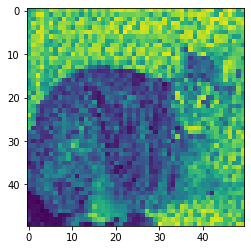

[array([[ 86,  77,  65, ..., 143, 134, 175],
       [122, 117, 110, ..., 122,  96, 107],
       [124, 115, 108, ..., 236, 216,  87],
       ...,
       [ 39,  44,  43, ...,  63,  52,  40],
       [ 20,  34,  75, ...,  82,  53,  41],
       [ 18,  19,  19, ...,  78,  54,  44]], dtype=uint8)
 array([1., 0.])]


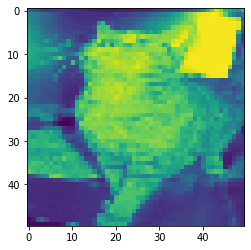

[array([[ 77,  93, 107, ..., 119, 131, 117],
       [ 78,  91, 108, ...,  84, 118, 124],
       [ 79,  85,  89, ...,  76,  89, 115],
       ...,
       [ 91,  79,  89, ...,  50,  51,  53],
       [ 86,  73,  88, ...,  36,  36,  42],
       [ 76,  75,  86, ...,  51,  52,  47]], dtype=uint8)
 array([0., 1.])]


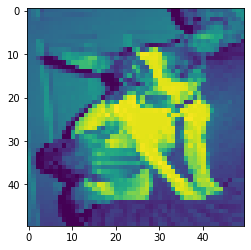

In [4]:
training_data=np.load('training_data.npy',allow_pickle=True)
print(training_data[0])
plt.imshow(training_data[0][0])
plt.show()

print(training_data[56])
plt.imshow(training_data[56][0])
plt.show()

print(training_data[5369])
plt.imshow(training_data[5369][0])
plt.show()

In [24]:
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(1,32,5)
        self.conv2=nn.Conv2d(32,64,5)
        self.conv3=nn.Conv2d(64,128,5)

        x=torch.randn(50,50).view(-1,1,50,50)
        self._toLinear=None
        self.convs(x)

        self.fc1=nn.Linear(self._toLinear,512)
        self.fc2=nn.Linear(512,2)
        
    def convs(self,x):
        x=F.max_pool2d(F.relu(self.conv1(x)),(2,2))
        x=F.max_pool2d(F.relu(self.conv2(x)),(2,2))
        x=F.max_pool2d(F.relu(self.conv3(x)),(2,2))
        
        if self._toLinear is None:
            self._toLinear=x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
            
        return x
    
    def forward(self,x):
        x = self.convs(x)
        x = x.view(-1, self._toLinear)  # .view is reshape ... this flattens X before 
        x = F.relu(self.fc1(x))
        x = self.fc2(x) # bc this is our output layer. No activation here.
        return F.softmax(x, dim=1)

In [28]:
#this is epoch trained on cpu
#Note the time taken to train in every epoch

net= Net()
optimizer=optim.Adam(net.parameters(),lr=0.001)

loss_function = nn.MSELoss()

X = torch.Tensor([i[0] for i in training_data]).view(-1,50,50)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.1  # lets reserve 10% of our data for validation
val_size = int(len(X)*VAL_PCT)

train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

BATCH_SIZE = 100
EPOCHS = 3


def train(net):
    for epoch in range(EPOCHS):
        for i in tqdm(range(0, len(train_X), BATCH_SIZE)): # from 0, to the len of x, stepping BATCH_SIZE at a time. [:50] ..for now just to dev
            #print(f"{i}:{i+BATCH_SIZE}")
            batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50)
            batch_y = train_y[i:i+BATCH_SIZE]

            net.zero_grad()

            outputs = net(batch_X)
            loss = loss_function(outputs, batch_y)
            loss.backward()
            optimizer.step()    # Does the update

        print(f"Epoch: {epoch}. Loss: {loss}")


def test(net):
    correct = 0
    total = 0
    with torch.no_grad():
        for i in tqdm(range(len(test_X))):
            real_class = torch.argmax(test_y[i])
            net_out = net(test_X[i].view(-1, 1, 50, 50))[0]  # returns a list, 
            predicted_class = torch.argmax(net_out)

            if predicted_class == real_class:
                correct += 1
            total += 1

    print("Accuracy: ", round(correct/total, 3))


In [22]:
net.train()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)

In [29]:
train(net)
test(net)

100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [02:14<00:00,  1.67it/s]


Epoch: 0. Loss: 0.25319063663482666


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [02:18<00:00,  1.63it/s]


Epoch: 1. Loss: 0.2179505079984665


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [02:24<00:00,  1.56it/s]


Epoch: 2. Loss: 0.17640922963619232


100%|█████████████████████████████████████████████████████████████████████████████| 2494/2494 [00:21<00:00, 118.24it/s]


Accuracy:  0.666


In [43]:
import torch
import torchvision
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import os
import cv2
import numpy as np
from tqdm import tqdm

class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(1,32,5)
        self.conv2=nn.Conv2d(32,64,5)
        self.conv3=nn.Conv2d(64,128,5)

        x=torch.randn(50,50).view(-1,1,50,50)
        self._toLinear=None
        self.convs(x)

        self.fc1=nn.Linear(self._toLinear,512)
        self.fc2=nn.Linear(512,2)
        
    def convs(self,x):
        x=F.max_pool2d(F.relu(self.conv1(x)),(2,2))
        x=F.max_pool2d(F.relu(self.conv2(x)),(2,2))
        x=F.max_pool2d(F.relu(self.conv3(x)),(2,2))
        
        if self._toLinear is None:
            self._toLinear=x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
            
        return x
    
    def forward(self,x):
        x = self.convs(x)
        x = x.view(-1, self._toLinear)  # .view is reshape ... this flattens X before 
        x = F.relu(self.fc1(x))
        x = self.fc2(x) # bc this is our output layer. No activation here.
        return F.softmax(x, dim=1)

    
training_data=np.load('training_data.npy',allow_pickle=True)    
net= Net()
optimizer=optim.Adam(net.parameters(),lr=0.001)

loss_function = nn.MSELoss()

X = torch.Tensor([i[0] for i in training_data]).view(-1,50,50)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.1  # lets reserve 10% of our data for validation
val_size = int(len(X)*VAL_PCT)

train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

#Here we will see GPU implementaion of the same model
#just add .to(device) before training data and testing data

if torch.cuda.is_available():
    device=torch.device("cuda:0")
    print("Running on gpu")
else:
    device=torch.device("cpu")
    print("running on cpu..")
    
BATCH_SIZE = 100
EPOCHS = 3


def train(net):
    for epoch in range(EPOCHS):
        for i in tqdm(range(0, len(train_X), BATCH_SIZE)): # from 0, to the len of x, stepping BATCH_SIZE at a time. [:50] ..for now just to dev
            #print(f"{i}:{i+BATCH_SIZE}")
            batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50)
            batch_y = train_y[i:i+BATCH_SIZE]
            
            batch_X,batch_y=batch_X.to(device),batch_y.to(device)
            
            net.zero_grad()

            outputs = net(batch_X)
            loss = loss_function(outputs, batch_y)
            loss.backward()
            optimizer.step()    # Does the update

        print(f"Epoch: {epoch}. Loss: {loss}")
        test(net)
        
test_X,test_y=test_X.to(device),test_y.to(device)       
def test(net):
    
    correct = 0
    total = 0
    with torch.no_grad():
        for i in tqdm(range(len(test_X))):
            real_class = torch.argmax(test_y[i]).to(device)
            net_out = net(test_X[i].view(-1, 1, 50, 50).to(device))[0]  # returns a list, 
            predicted_class = torch.argmax(net_out)

            if predicted_class == real_class:
                correct += 1
            total += 1

    print("Accuracy: ", round(correct/total, 3))

Running on gpu


In [44]:
net=Net().to(device)
train(net)

100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:10<00:00, 21.44it/s]


Epoch: 0. Loss: 0.2499711662530899


100%|█████████████████████████████████████████████████████████████████████████████| 2494/2494 [00:03<00:00, 803.97it/s]


Accuracy:  0.522


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:10<00:00, 21.17it/s]


Epoch: 1. Loss: 0.2499711662530899


100%|█████████████████████████████████████████████████████████████████████████████| 2494/2494 [00:03<00:00, 800.51it/s]


Accuracy:  0.522


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:10<00:00, 21.08it/s]


Epoch: 2. Loss: 0.2499711662530899


100%|█████████████████████████████████████████████████████████████████████████████| 2494/2494 [00:03<00:00, 709.97it/s]


Accuracy:  0.522
